In [1]:
def fibonacci(n):
    """
    Return the nth Fibonacci number given by:
    
    x_0=x_1=1
    x_{n} = x_{n-1} + x_{n-2}
    
    """
    if n in [0, 1]:
        return 1
    return fibonacci(n - 1) + fibonacci(n - 2)

In [2]:
for n in range(5):
    print(fibonacci(n))

1
1
2
3
5


## Newton's law of cooling

> Newton's law of cooling states that the rate of heat loss of a body is directly proportional to the difference in the temperatures between the body and its surroundings.

\\[
 \frac{dT}{dt} = K (T_{\text{room}} - T(t))
\\]

In [3]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt

T = sym.Function("T")
K = sym.Symbol("K")
T_room = sym.Symbol("T_room")
t = sym.Symbol("t")
eqn = sym.Eq(sym.Derivative(T(t), t), K * (T_room - T(t)))
eqn

Eq(Derivative(T(t), t), K*(T_room - T(t)))

We can now get a closed form solution for this equation:

In [4]:
sol = sym.dsolve(eqn, T(t), ics={T(0): 100})
sol

Eq(T(t), T_room + (100 - T_room)*exp(-K*t))

In [5]:
particular_solution = sol.rhs.subs({K: 1 / 10, T_room: 30})
particular_solution

30 + 70*exp(-0.1*t)

In [6]:
time_points = np.linspace(0, 70, 500)
temperatures = [particular_solution.subs({t: t_val}) 
                for t_val in time_points]

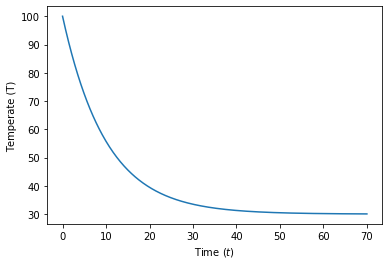

In [7]:
plt.figure()
plt.plot(time_points, temperatures)
plt.xlabel("Time ($t$)")
plt.ylabel("Temperate (T)");

## Solving the SIR model exactly

In [8]:
S, I, R = sym.Function("S"), sym.Function("I"), sym.Function("V")
N, mu, alpha, beta, t = sym.symbols("N, mu, alpha, beta, t")
eq1 = sym.Derivative(S(t), t) - (- alpha * S(t) * I(t) - mu * R(t))
eq2 = sym.Derivative(I(t), t) - (alpha * I(t) * S(t) / N  - beta * I(t))
eq3 = sym.Derivative(R(t), t) - (beta * I(t) + mu * R(t))
sym.dsolve((eq1, eq2, eq3))

NotImplementedError: 

This is not unexpected: https://www.sciencedirect.com/science/article/abs/pii/S009630031400383X

In [9]:
def dx(x, t, alpha, beta):
    """
    Returns the value of the derivative of the basic SIR model.
    
    x is an array:
    
    x[0] = S
    x[1] = I
    x[2] = R
    
    alpha is the rate at which one becomes infected.
    beta the recovery rate
    """
    return (- alpha * x[1] * x[0],
            alpha * x[1] * x[0]  - beta * x[1],
            beta * x[1])

In [10]:
x = 1, 10, 0
alpha = 1 / 1000
beta = 1 / 5

dx(x=x, t=0, alpha=alpha, beta=beta)

(-0.01, -1.99, 2.0)

We will now use a mathematical tool called numerical integration.

In [11]:
import scipy.integrate

N = 1000

ts = np.linspace(0, 50, 500)
xs = scipy.integrate.odeint(
    func=dx, 
    y0=np.array([N - 1, 1, 0]), 
    t=ts, 
    args=(alpha, beta),
)

In [12]:
xs

array([[9.99000000e+02, 1.00000000e+00, 0.00000000e+00],
       [9.98895789e+02, 1.08334661e+00, 2.08640911e-02],
       [9.98782906e+02, 1.17362712e+00, 4.34670116e-02],
       ...,
       [6.98390877e+00, 3.86891922e-01, 9.92629199e+02],
       [6.98364063e+00, 3.79481209e-01, 9.92636878e+02],
       [6.98337764e+00, 3.72212435e-01, 9.92644410e+02]])

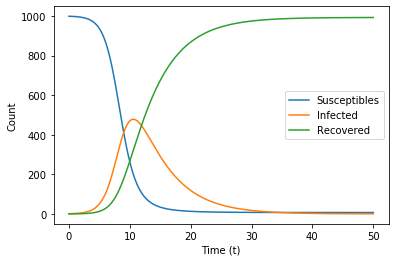

In [13]:
S, I, R = xs.T
plt.figure()
plt.plot(ts, S, label="Susceptibles")
plt.plot(ts, I, label="Infected")
plt.plot(ts, R, label="Recovered")
plt.legend()
plt.xlabel("Time (t)")
plt.ylabel("Count");

We can see the effect of flattening the curve:

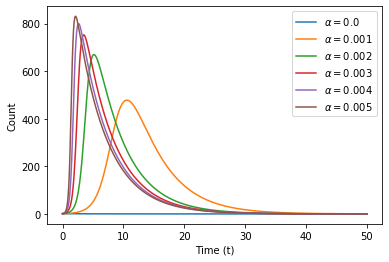

In [14]:
alpha_rates = np.linspace(0, 1 / 200, 6)

plt.figure()
for alpha in alpha_rates:
    xs = scipy.integrate.odeint(func=dx, y0=np.array([N - 1, 1, 0]), t=ts, args=(alpha, beta))
    S, I, R = xs.T
    plt.plot(ts, I, label=f"$\\alpha={alpha}$")
plt.legend()
plt.xlabel("Time (t)")
plt.ylabel("Count");

What about reinfections?

In [15]:
def dx(x, t, alpha, beta, kappa=0):
    """
    Returns the value of the derivative of the basic SIR model with reinfections allowed.
    
    x is an array:
    
    x[0] = S
    x[1] = I
    x[2] = R
    
    alpha is the rate at which one becomes infected.
    beta the recovery rate
    kappa is the probability with which someone who recovers 
          returns to the susceptible population.
    """
    return (- alpha * x[1] * x[0] + kappa * beta * x[1],
            alpha * x[1] * x[0] - beta * x[1],
            (1 - kappa) * beta * x[1])

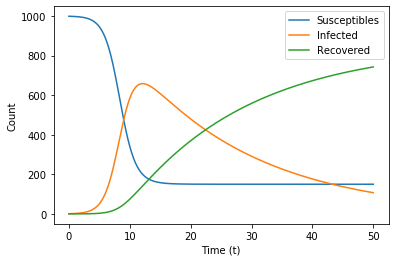

In [16]:
kappa = 3 / 4
alpha = 1 / 1000
beta = 1 / 5
xs = scipy.integrate.odeint(
    func=dx, 
    y0=np.array([N - 1, 1, 0]), 
    t=ts, 
    args=(alpha, beta, kappa),
)
S, I, R = xs.T
plt.figure()
plt.plot(ts, S, label="Susceptibles")
plt.plot(ts, I, label="Infected")
plt.plot(ts, R, label="Recovered")
plt.legend()
plt.xlabel("Time (t)")
plt.ylabel("Count");

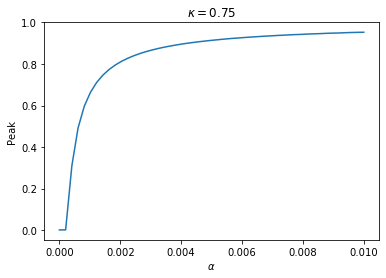

In [17]:
alpha_rates = np.linspace(0, 1 / 100, 50)
kappa = 3 / 4
max_percent_of_infected = []
for alpha in alpha_rates:
    xs = scipy.integrate.odeint(
        func=dx, 
        y0=np.array([N - 1, 1, 0]), 
        t=ts, 
        args=(alpha, beta, kappa)
    )
    S, I, R = xs.T
    max_percent_of_infected.append(max(I) / N)

plt.figure()
plt.plot(alpha_rates, max_percent_of_infected)
plt.xlabel("$\\alpha$")
plt.ylabel("Peak")
plt.title(f"$\kappa={kappa}$");

How much is the peak affected by the reinfection rate?

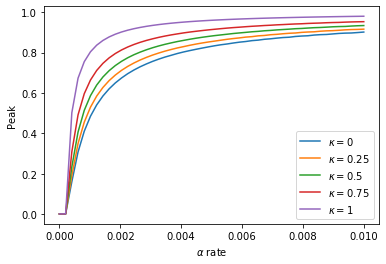

In [18]:
plt.figure()
for kappa in [0, 1/4, 1/2, 3/4, 1]:
    max_percent_of_infected = []
    for alpha in alpha_rates:
        xs = scipy.integrate.odeint(
            func=dx, 
            y0=np.array([N - 1, 1, 0]), 
            t=ts, 
            args=(alpha, beta, kappa)
        )
        S, I, R = xs.T
        max_percent_of_infected.append(max(I) / N)

    plt.plot(
        alpha_rates, 
        max_percent_of_infected, 
        label=f"$\kappa={kappa}$"
    )
plt.xlabel("$\\alpha$ rate")
plt.ylabel("Peak")
plt.legend();

What about a vaccine?

In [19]:
def dx(x, t, alpha, beta, kappa=0, mu=0):
    """
    Returns the value of the derivative of the basic SIR model with reinfections allowed.
    
    x is an array:
    
    x[0] = S
    x[1] = I
    x[2] = R
    
    alpha is the rate at which one becomes infected.
    beta the recovery rate
    kappa is the rate at which someone who recovers 
          returns to the susceptible population.
    mu is the rate at which the susceptible population 
       is vaccinated
    """
    return (- alpha * x[1] * x[0] + kappa * beta * x[1] - mu * x[0],
            alpha * x[1] * x[0] - beta * x[1],
            (1 - kappa) * beta * x[1] + mu * x[0])

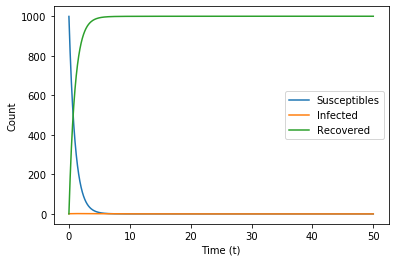

In [20]:
kappa = 3 / 4
mu = 1
alpha = 1 / 1000
xs = scipy.integrate.odeint(
    func=dx, 
    y0=np.array([N - 1, 1, 0]), 
    t=ts, 
    args=(alpha, beta, kappa, mu),
)
S, I, R = xs.T
plt.figure()
plt.plot(ts, S, label="Susceptibles")
plt.plot(ts, I, label="Infected")
plt.plot(ts, R, label="Recovered")
plt.legend()
plt.xlabel("Time (t)")
plt.ylabel("Count");

What about deaths?

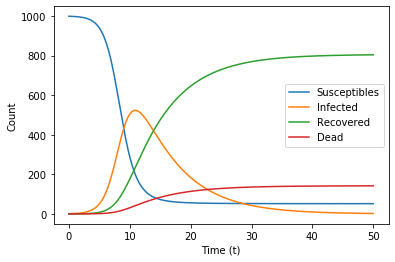

In [21]:
def dx(x, t, alpha, beta, p=1, kappa=0, mu=0):
    """
    Returns the value of the derivative of the basic SIRD model with reinfections allowed.
    
    x is an array:
    
    x[0] = S
    x[1] = I
    x[2] = R
    x[3] = D (deaths)
    
    alpha is the rate at which one becomes infected.
    beta the recovery rate
    kappa is the rate at which someone who recovers 
          returns to the susceptible population.
    mu is the rate at which the susceptible population 
       is vaccinated
    p is the probability of surviving the disease when 
      recovering
    """
    return (- alpha * x[1] * x[0] + kappa * beta * x[1] - mu * x[0],
            alpha * x[1] * x[0] - beta * x[1],
            p * (1 - kappa) * beta * x[1] + mu * x[0],
            (1 - p) * (1 - kappa) * beta * x[1])

kappa = 1 / 4
mu = 0
p = .85
xs = scipy.integrate.odeint(
    func=dx, 
    y0=np.array([N - 1, 1, 0, 0]), 
    t=ts, 
    args=(alpha, beta, p, kappa, mu),
)
S, I, R, D = xs.T
plt.figure()
plt.plot(ts, S, label="Susceptibles")
plt.plot(ts, I, label="Infected")
plt.plot(ts, R, label="Recovered")
plt.plot(ts, D, label="Dead")
plt.legend()
plt.xlabel("Time (t)")
plt.ylabel("Count");

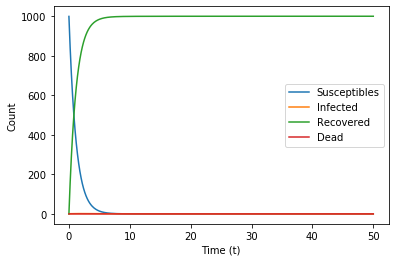

In [22]:
kappa = 3 / 4
mu = .85
p = .85
xs = scipy.integrate.odeint(
    func=dx, 
    y0=np.array([N - 1, 1, 0, 0]), 
    t=ts, 
    args=(alpha, beta, p, kappa, mu),
)
S, I, R, D = xs.T

plt.figure()
plt.plot(ts, S, label="Susceptibles")
plt.plot(ts, I, label="Infected")
plt.plot(ts, R, label="Recovered")
plt.plot(ts, D, label="Dead")
plt.legend()
plt.xlabel("Time (t)")
plt.ylabel("Count");